**Sentiment Analysis using MLP, CNN and RNN**

In this tutorial I'll show you how to use Deep Neural Networks with the keras library to quickly build sentence classification.

**Mounting Google Drive**

with the following command

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/TCS-Deep-Learning-Session-2020/data

/content/drive/My Drive/TCS-Deep-Learning-Session-2020/data


**Import keras library**

In [0]:

from __future__ import print_function

from keras.models import Sequential
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input,  Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Embedding, LSTM, GRU, SimpleRNN

Using TensorFlow backend.


**To avoid mismatch tensorflow/keras version**

https://github.com/keras-team/keras/issues/13684

In [0]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


**import additional library**

In [0]:
import os
import csv
import numpy as np
from numpy.random import RandomState
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
prng = RandomState(1234567890)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Setting some hyper-parameters and global path for the model**

In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000

EMBEDDING_DIM = 50
No_of_Epoch = 5
BATCH_SIZE = 256
GLOVE_FILE = 'glove.6B.50d.txt'

TRAIN_DATA_FILE = "IMDB_dataset.csv"

VALIDATION_SPLIT = 0.2

**Data Pre-processing**

In [0]:
### main code to load the dataset
def get_training_and_validation_sets():
    print("Loading dataset...")
    X_raw, Y_raw = load_data_set()  ## Loading the dataset from file
    print("Processing dataset...")
    X_processed, Y_processed, word_index = tokenize_data(X_raw, Y_raw) ## Tokenizing and padding the sentences
    x_train, x_val, y_train, y_val = split_the_data(X_processed, Y_processed) ## Splitting for train and validation
    print("Dataset processed.")
    print("Training sample shape", x_train.shape)
    return word_index, x_train, x_val, y_train, y_val

### Split the whole dataset into train and val set
def split_the_data(X_processed, Y_processed):
    indices = np.arange(X_processed.shape[0])
    prng.shuffle(indices)
    X_processed = X_processed[indices]
    Y_processed = Y_processed[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * X_processed.shape[0])
    x_train = X_processed[:-nb_validation_samples]
    y_train = Y_processed[:-nb_validation_samples]
    x_val = X_processed[-nb_validation_samples:]
    y_val = Y_processed[-nb_validation_samples:]
    return x_train, x_val, y_train, y_val

### mapping the sentences to token indices 
def tokenize_data(X_raw, Y_raw):
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_raw)
    sequences = tokenizer.texts_to_sequences(X_raw)
    word_index = tokenizer.word_index
    X_processed = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    #print (Y_raw)
    Y_processed = to_categorical(np.asarray(Y_raw), 2)
    #print (Y_processed)
    return X_processed, Y_processed, word_index


## loading dataset from file
def load_data_set():
    X = []
    Y = []
    postive_count=0
    with open(TRAIN_DATA_FILE, "r") as f:
        reader = csv.reader(f, delimiter=",")
        for i, line in enumerate(reader):
            is_positive = line[1]=="positive"
            if is_positive and postive_count<2500:
                postive_count+=1
                text = line[0]
                X.append(text)
                Y.append(1)
            elif i-postive_count< 2500:
                text = line[0]
                X.append(text)
                Y.append(0)
        print ("Total Postive Sample", len([i for i in Y if i==1]))
        print ("Total Negative Sample",len([i for i in Y if i==0]))
    return X,Y


**Utility functions for Word Embedding**

In [0]:
## Load pre-trained embedding

def get_embeddings():
    embeddings = {}
    with open(GLOVE_FILE, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings


## make embedding layer with pre-trained embeddings
def make_embedding_layer(word_index):
    embeddings = get_embeddings()
    nb_words = max(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
    return embedding_layer





**MLP Model for text classification**

In [0]:
def make_MLPmodel(labels_index, word_index=None):
    if word_index is not None:
      emb_layer = make_embedding_layer(word_index)  ## Pre-traine emb
    else:
      emb_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    model = Sequential([
        emb_layer,
        Dense(10, activation='relu'),
        Flatten(),
        Dense(len(labels_index), activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

**CNN Model for text classification**
<!-- ![alt text](https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png) -->
<img src="https://missinglink.ai/wp-content/uploads/2019/03/1D-convolutional-example_2x.png" alt="drawing" width="500"/>

Credit: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/



In [0]:
def make_CNNmodel(labels_index, word_index=None):
    if word_index is not None:
      emb_layer = make_embedding_layer(word_index)
    else:
      emb_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    model = Sequential([
        emb_layer,
        Conv1D(512, 3, activation='relu'),
        MaxPooling1D(5),
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(len(labels_index), activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model


**RNN Model for text classification**

In [0]:
def make_RNNmodel(labels_index, word_index=None, rnn_type='gru'):
    if word_index is not None:
      emb_layer = make_embedding_layer(word_index)
    else:
      emb_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    if rnn_type=='gru':
      rnn = GRU(128)
    else:
      rnn = LSTM(128)
    model = Sequential([
        emb_layer,
        rnn,
        Dense(128, activation='relu'),
        Dense(len(labels_index), activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model


**Training and Evaluation functions**

In [0]:
def train(model, x_train, x_val, y_train, y_val, network):
    print("Training "+ network)
    cb = [ModelCheckpoint("weights_"+network+".h5", save_best_only=True, save_weights_only=False)]
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), nb_epoch=No_of_Epoch, batch_size=BATCH_SIZE, callbacks=cb)
    try:
        os.remove("model_"+network+".h5")
    except OSError:
        pass
    model.save("model_"+network+".h5")
    return history

def evaluate(expected_out, predicted_out):
    expected_categories = [np.argmax(x) for x in expected_out]
    predicted_categories = [np.argmax(x) for x in predicted_out]
    cf_matrix = confusion_matrix(expected_categories, predicted_categories)
    print("Confusion Matrix")
    sns.heatmap(cf_matrix, annot=True)   ## plotting confusion matrix
    print("Classification Report")      ## classification report
    report = classification_report(y_pred=predicted_categories, y_true=expected_categories, target_names=['Negative', 'Positive'])
    print(report)

**Plot the Learning Curve**

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

**Build Deep NN Models**

In [0]:
labels_index = { 'Negative': 0, 'Positive': 1}

word_index, x_train, x_val, y_train, y_val = get_training_and_validation_sets()
print("Builing MLP model...")
model_MLP = make_MLPmodel(labels_index, word_index)
print("Builing CNN model...")
model_CNN = make_CNNmodel(labels_index, word_index)
print("Builing RNN model...")
model_RNN = make_RNNmodel(labels_index, word_index)
print("All models builded.")


Loading dataset...
Total Postive Sample 2500
Total Negative Sample 2500
Processing dataset...


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Dataset processed.
Training sample shape (4000, 100)
Builing MLP model...
Builing CNN model...
Builing RNN model...
All models builded.


**Visualize Model and i/o shapes**

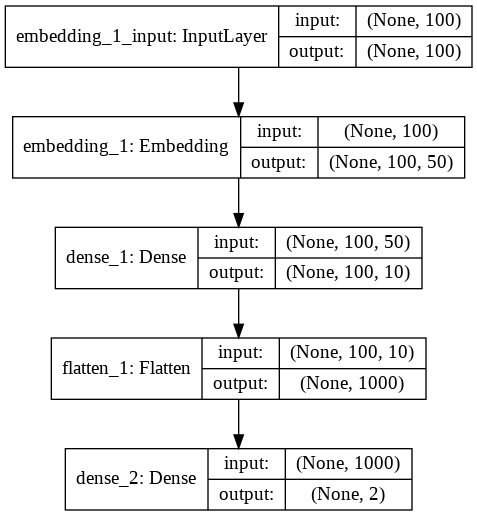

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model_MLP, to_file='model_mlp_plot.png', show_shapes=True, show_layer_names=True)

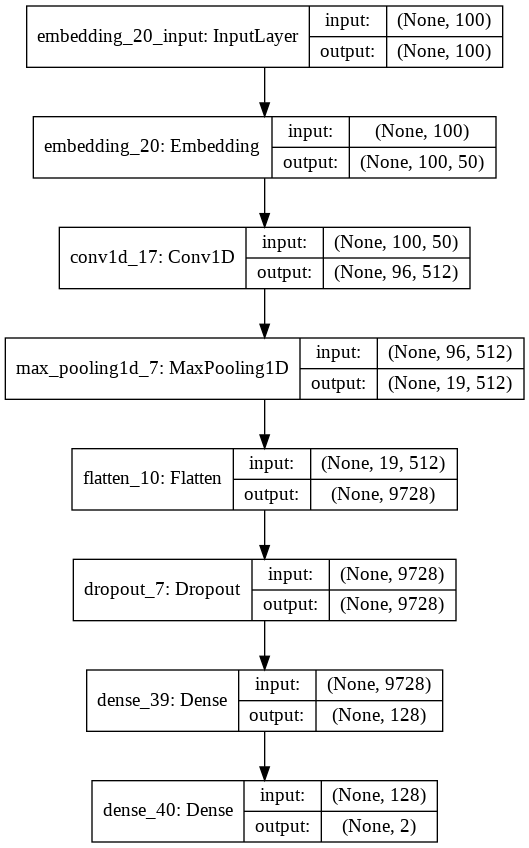

In [0]:
plot_model(model_CNN, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
plot_model(model_RNN, to_file='model_rnn_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
print(model_RNN.summary())   ## Model Summary

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 50)           2168400   
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               68736     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 258       
Total params: 2,253,906
Trainable params: 85,506
Non-trainable params: 2,168,400
_________________________________________________________________
None


Training MLP


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 0s 110us/step - loss: 0.7341 - acc: 0.5165 - val_loss: 0.7015 - val_acc: 0.5410
Epoch 2/5
4000/4000 [==============================] - 0s 40us/step - loss: 0.6919 - acc: 0.5590 - val_loss: 0.6834 - val_acc: 0.5570
Epoch 3/5
4000/4000 [==============================] - 0s 39us/step - loss: 0.6583 - acc: 0.6012 - val_loss: 0.6662 - val_acc: 0.5970
Epoch 4/5
4000/4000 [==============================] - 0s 41us/step - loss: 0.6272 - acc: 0.6490 - val_loss: 0.6575 - val_acc: 0.6070
Epoch 5/5
4000/4000 [==============================] - 0s 41us/step - loss: 0.5992 - acc: 0.6793 - val_loss: 0.6313 - val_acc: 0.6540
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

    Negative       0.67      0.64      0.65       507
    Positive       0.64      0.67      0.66       493

    accuracy                           0.65      1000
   macro avg       0.65 

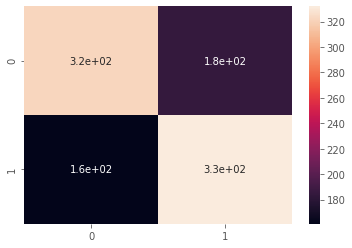

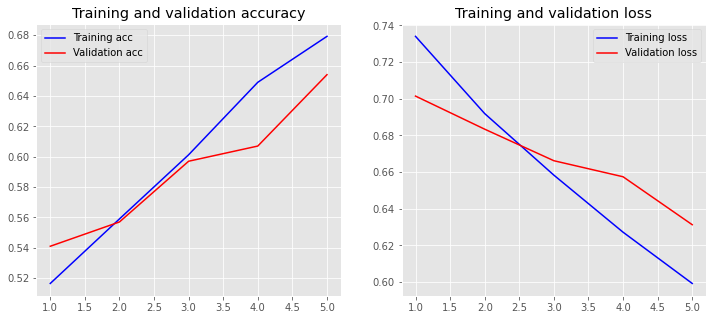

In [0]:
#@title Default title text
## Training the model
mlp_history = train(model_MLP, x_train, x_val, y_train, y_val,"MLP")
## Validating the model on val set
valid_predicted_out = model_MLP.predict(x=x_val, batch_size=BATCH_SIZE)
## Evaluating the performance
evaluate(y_val, valid_predicted_out)
## Plotting learning curve
plot_history(mlp_history)

Training CNN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6942 - acc: 0.5130 - val_loss: 0.7042 - val_acc: 0.5040
Epoch 2/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6914 - acc: 0.5282 - val_loss: 0.6893 - val_acc: 0.5010
Epoch 3/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6738 - acc: 0.5813 - val_loss: 0.6587 - val_acc: 0.6030
Epoch 4/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6264 - acc: 0.6440 - val_loss: 0.6567 - val_acc: 0.6250
Epoch 5/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5659 - acc: 0.7050 - val_loss: 0.6515 - val_acc: 0.6420
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

    Negative       0.61      0.79      0.69       496
    Positive       0.71      0.50      0.58       504

    accuracy                           0.64      1000
   macro avg       0.66      0

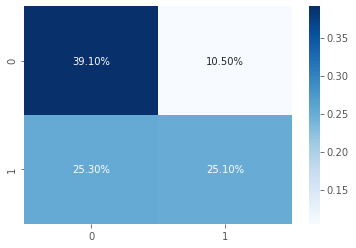

In [0]:
train(model_CNN, x_train, x_val, y_train, y_val,"CNN")

valid_predicted_out = model_CNN.predict(x=x_val, batch_size=BATCH_SIZE)

evaluate(y_val, valid_predicted_out)


Training RNN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 10s 3ms/step - loss: 0.6873 - acc: 0.5418 - val_loss: 0.6646 - val_acc: 0.5830
Epoch 2/5
4000/4000 [==============================] - 10s 3ms/step - loss: 0.6531 - acc: 0.6212 - val_loss: 0.6354 - val_acc: 0.6370
Epoch 3/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6198 - acc: 0.6570 - val_loss: 0.5852 - val_acc: 0.6750
Epoch 4/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.5602 - acc: 0.7163 - val_loss: 0.5534 - val_acc: 0.7190
Epoch 5/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.5318 - acc: 0.7375 - val_loss: 0.4988 - val_acc: 0.7590
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76       496
    Positive       0.76      0.76      0.76       504

    accuracy                           0.76      1000
   macro avg       0.76  

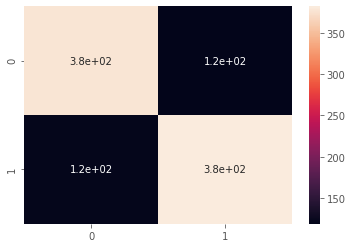

In [0]:
train(model_RNN, x_train, x_val, y_train, y_val,"RNN")
valid_predicted_out = model_RNN.predict(x=x_val, batch_size=BATCH_SIZE)
evaluate(y_val, valid_predicted_out)


**Predicting the sentiment of unseen text**

In [0]:
from keras.models import load_model
def tokenize_data_test(X_raw):
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_raw)
    sequences = tokenizer.texts_to_sequences(X_raw)
    word_index = tokenizer.word_index
    X_processed = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return X_processed, word_index

In [0]:
X_raw=["It is shame."]
X, word_index = tokenize_data_test(X_raw)
model = load_model('model_CNN.h5')
model.load_weights("weights_CNN.h5")
predictions = model.predict(x=X, batch_size=BATCH_SIZE)
for index, txt in enumerate(X_raw):
    is_positive = predictions[index][1] >= 0.5
    status_txt = "Positive" if is_positive else "Negative"
    print("[",status_txt,"] ", txt)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


[ Negative ]  It is shame.


In [0]:
X_raw=["It is shame."]
X, word_index = tokenize_data_test(X_raw)
model = load_model('model_MLP.h5')
model.load_weights("weights_MLP.h5")
predictions = model.predict(x=X, batch_size=BATCH_SIZE)
for index, txt in enumerate(X_raw):
    is_positive = predictions[index][1] >= 0.5
    status_txt = "Positive" if is_positive else "Negative"
    print("[",status_txt,"] ", txt)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


[ Negative ]  It is shame.
